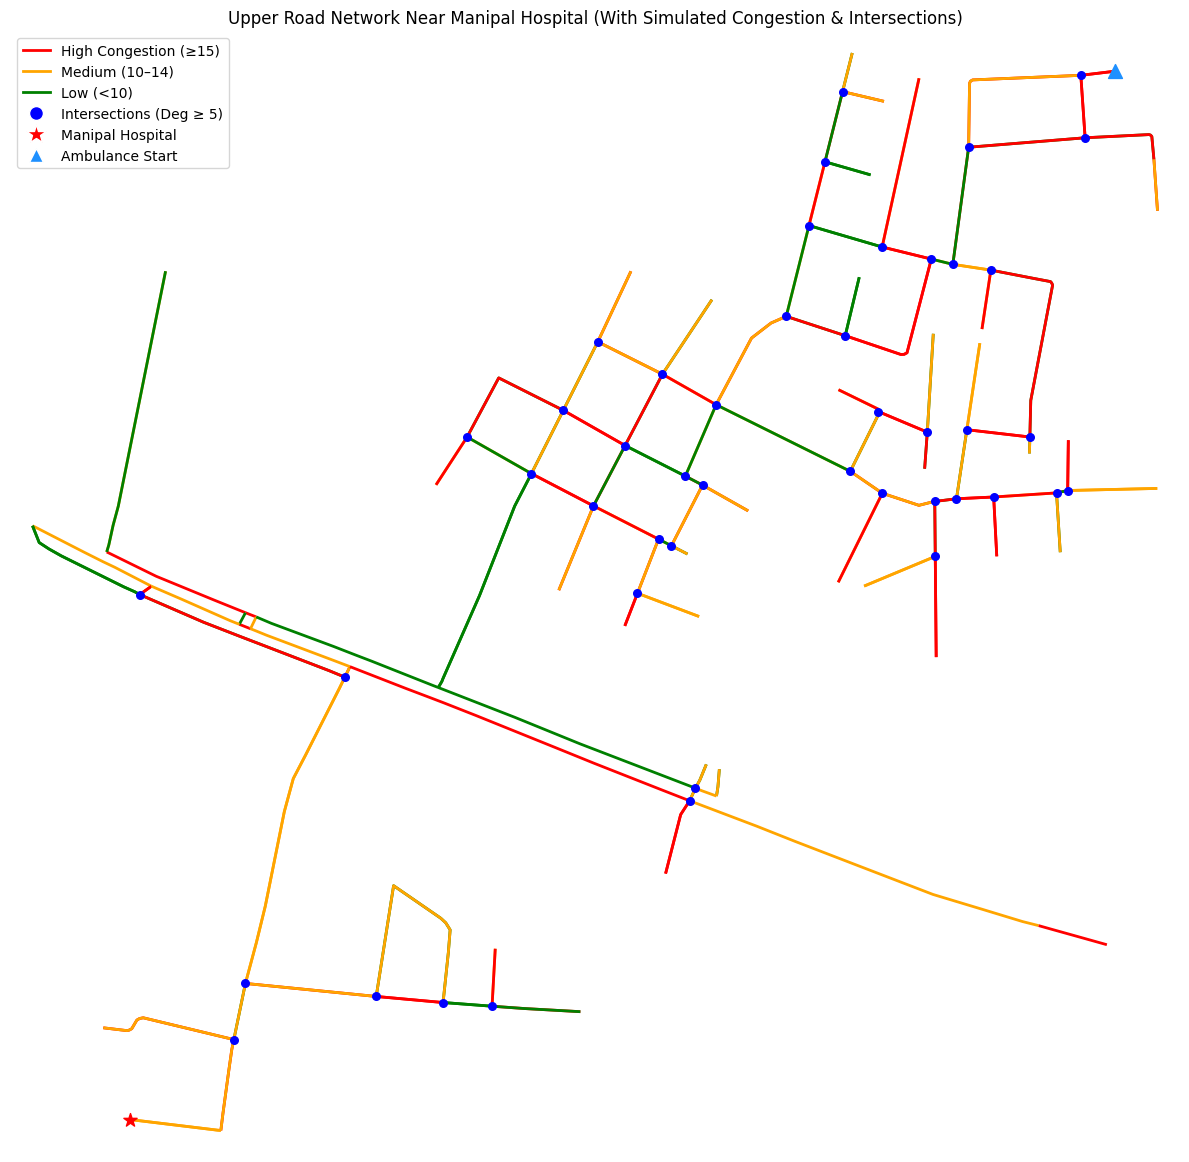

In [19]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
!pip install osmnx haversine qiskit qiskit-optimization --quiet

# Step 1: Define settings and coordinates
ox.settings.use_cache = True
ox.settings.log_console = True

# Coordinates near Manipal Hospital Sarjapur Road (upper section)
lat, lon = 12.9116, 77.6866
point = (lat, lon)

# Step 2: Get the graph within 500m radius (focusing on upper region)
G = ox.graph_from_point(point, dist=500, dist_type='bbox', network_type='drive')

# Step 3: Simplify and project graph
#G = ox.simplify_graph(G)
G_proj = ox.project_graph(G)

# Step 4: Simulate congestion by assigning random weights to edges
for u, v, k, data in G_proj.edges(keys=True, data=True):
    weight = random.randint(5, 20)
    data['weight'] = weight

# Step 5: Define color for congestion levels
def get_edge_color(weight):
    if weight >= 15:
        return 'red'      # High congestion
    elif weight >= 10:
        return 'orange'   # Medium congestion
    else:
        return 'green'    # Low congestion

edge_colors = [get_edge_color(data['weight']) for u, v, k, data in G_proj.edges(keys=True, data=True)]

# Step 6: Identify intersections with high degree
degree_threshold = 5
intersection_nodes = [node for node, degree in dict(G_proj.degree()).items() if degree >= degree_threshold]

# Step 7: Plot everything
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(
    G_proj,
    ax=ax,
    node_size=0,
    edge_color=edge_colors,
    edge_linewidth=2,
    show=False,
    close=False,
    bgcolor='white'
)

# Step 8: Plot intersection nodes (highlighted in blue)
x_nodes = [G_proj.nodes[n]['x'] for n in intersection_nodes]
y_nodes = [G_proj.nodes[n]['y'] for n in intersection_nodes]
ax.scatter(x_nodes, y_nodes, c='blue', s=30, label='Intersections (Deg ≥ 5)', zorder=3)

# Step 9: Plot hospital location
ax.scatter(
    G_proj.nodes[ox.nearest_nodes(G_proj, lon, lat)]['x'],
    G_proj.nodes[ox.nearest_nodes(G_proj, lon, lat)]['y'],
    c='red', s=100, marker='*', label='Manipal Hospital', zorder=4
)

# Step 10: Legend and title
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='High Congestion (≥15)'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Medium (10–14)'),
    plt.Line2D([0], [0], color='green', lw=2, label='Low (<10)'),
    plt.Line2D([0], [0], marker='o', color='w', label='Intersections (Deg ≥ 5)',
               markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='*', color='w', label='Manipal Hospital',
               markerfacecolor='red', markersize=15)
]
ax.legend(handles=legend_elements, loc='upper left')
plt.title("Upper Road Network Near Manipal Hospital (With Simulated Congestion & Intersections)")
plt.axis('off')
plt.tight_layout()
plt.savefig("manipal_map.png",dpi=300, bbox_inches='tight')
import networkx as nx
from matplotlib.lines import Line2D

# Step: Find the top-right-most node by maximizing (x + y)
top_right_node = max(G_proj.nodes(data=True), key=lambda x: x[1]['x'] + x[1]['y'])
ambulance_node_id = top_right_node[0]
ambulance_x = top_right_node[1]['x']
ambulance_y = top_right_node[1]['y']

# Step: Plot the ambulance start point
ax.scatter(ambulance_x, ambulance_y, color='dodgerblue', s=100, marker='^', label='Ambulance Start')

# Step: Add to legend (only if not already added)
legend_elements.append(Line2D([0], [0], marker='^', color='w', label='Ambulance Start',
                              markerfacecolor='dodgerblue', markersize=10))
ax.legend(handles=legend_elements, loc='upper left')
plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# --- Weight prep: create w_class (rounded) and w_qaoa (tiny jitter) ---
import numpy as np, hashlib

# 0) Base weight from your graph
for u, v, d in G_proj.edges(data=True):
    d['w_base'] = float(d.get('weight', d.get('length', 1.0)))

# 1) Classical weights: round to create near-ties
bucket = 3.0   # try 1.0–3.0
for u, v, d in G_proj.edges(data=True):
    d['w_class'] = round(d['w_base'] / bucket) * bucket

# 2) QAOA weights: tiny deterministic jitter to break ties differently
eps = 0.015    # ~0.8% jitter (try 0.005–0.015)
for u, v, d in G_proj.edges(data=True):
    # stable per-edge sign using a hash of the undirected pair
    key = f"{min(u,v)}-{max(u,v)}"
    h = int(hashlib.sha1(key.encode()).hexdigest(), 16)
    sign = 1 if (h & 1) else -1
    d['w_qaoa'] = d['w_class'] * (1 + sign * eps)

# Helper: simple undirected from a Multi(Di)Graph with a chosen weight attribute
def to_simple_undirected(G_multi, weight_attr="w_class"):
    Gs = nx.Graph()
    for u, v, data in G_multi.edges(data=True):
        w = float(data.get(weight_attr, data.get('weight', data.get('length', 1.0))))
        a, b = (u, v) if u <= v else (v, u)
        if Gs.has_edge(a, b):
            if w < Gs[a][b]["weight"]:
                Gs[a][b]["weight"] = w
        else:
            Gs.add_edge(a, b, weight=w)
    return Gs

In [21]:
xs = [data['x'] for _, data in G_proj.nodes(data=True)]
ys = [data['y'] for _, data in G_proj.nodes(data=True)]
print("Longitude range:", min(xs), "to", max(xs))
print("Latitude range:", min(ys), "to", max(ys))

import heapq

# Convert node data to lists of lat/lon
node_coords = [(node, data['y'], data['x']) for node, data in G_proj.nodes(data=True)]

# Hospital = bottom-left (min lat + min lon)
hospital_node_id = min(node_coords, key=lambda x: (x[1], x[2]))[0]

# Ambulance = top-right (max lat + max lon)
ambulance_node_id = max(node_coords, key=lambda x: (x[1], x[2]))[0]

print("Ambulance node ID:", ambulance_node_id)
print("Hospital node ID:", hospital_node_id)

# Plot to confirm
#fig, ax = ox.plot_graph(G_proj, node_size=0, edge_color='gray', edge_linewidth=0.8, show=False, close=False)
#ax.scatter(G_proj.nodes[ambulance_node_id]['x'], G_proj.nodes[ambulance_node_id]['y'], c='blue', s=100, label='Ambulance')
#ax.scatter(G_proj.nodes[hospital_node_id]['x'], G_proj.nodes[hospital_node_id]['y'], c='red', s=100, marker='*', label='Hospital')
#plt.legend()
#plt.title("Fixed Ambulance and Hospital Positions")
#plt.tight_layout()
#plt.show()

Longitude range: 791044.3471436468 to 791993.7783050317
Latitude range: 1428396.3710876463 to 1429305.6872228417
Ambulance node ID: 3500405710
Hospital node ID: 1314077248


In [22]:
# --- Utilities for near-degenerate instance creation (same weights for all solvers) ---
import heapq
import networkx as nx
from networkx.algorithms.simple_paths import shortest_simple_paths

def to_simple_undirected(G_multi, weight_attr="weight"):
    Gs = nx.Graph()
    for u, v, d in G_multi.edges(data=True):
        w = float(d.get(weight_attr, d.get('weight', d.get('length', 1.0))))
        a, b = (u, v) if u <= v else (v, u)
        if Gs.has_edge(a, b):
            if w < Gs[a][b]["weight"]:
                Gs[a][b]["weight"] = w
        else:
            Gs.add_edge(a, b, weight=w)
    return Gs

def path_cost_simple(Gs, path, w='weight'):
    return nx.path_weight(Gs, path, weight=w)

def edge_set(path):
    return set((min(u,v), max(u,v)) for u,v in zip(path[:-1], path[1:]))

def harden_instance_via_gap_shaping(
    G_proj, s, t,
    weight_attr="weight",
    k=5,
    target_gap=0.2,     # aim for this P2 - P1 gap (units of your weights)
    max_rel_bump=0.02   # cap per-edge increase (e.g., ≤ +2%)
):
    """
    Make P1 and P2 nearly tie by increasing weights on edges unique to P1.
    Applies SAME new weights into G_proj[...][weight_attr], affecting all solvers equally.
    Returns (applied: bool, info: dict).
    """
    Gs = to_simple_undirected(G_proj, weight_attr)
    paths = list(heapq.nsmallest(
        k,
        shortest_simple_paths(Gs, s, t, weight="weight"),
        key=lambda p: path_cost_simple(Gs, p, "weight")
    ))
    if len(paths) < 2:
        return False, {"reason": "fewer than 2 simple paths"}

    p1, p2 = paths[0], paths[1]
    c1, c2 = path_cost_simple(Gs, p1), path_cost_simple(Gs, p2)
    delta = c2 - c1
    if delta <= target_gap:
        return False, {"reason": "already near-degenerate", "c1": c1, "c2": c2, "delta": delta, "p1": p1, "p2": p2}

    E1, E2 = edge_set(p1), edge_set(p2)
    unique1 = list(E1 - E2)
    if not unique1:
        return False, {"reason": "P1 and P2 share almost all edges", "c1": c1, "c2": c2, "delta": delta, "p1": p1, "p2": p2}

    # total weight on P1-unique edges
    Wuniq = sum(Gs[a][b]["weight"] for a,b in unique1)
    need = delta - target_gap
    eps = min(max_rel_bump, need / max(Wuniq, 1e-12))
    if eps <= 0:
        return False, {"reason": "no bump needed", "c1": c1, "c2": c2, "delta": delta}

    # apply the same multiplicative bump to the chosen weight_attr on P1-unique edges
    for a, b in unique1:
        if G_proj.has_edge(a, b):
            for kkey in list(G_proj[a][b]):
                base = float(G_proj[a][b][kkey].get(weight_attr, G_proj[a][b][kkey].get('weight', 1.0)))
                G_proj[a][b][kkey][weight_attr] = base * (1.0 + eps)
        if G_proj.has_edge(b, a):
            for kkey in list(G_proj[b][a]):
                base = float(G_proj[b][a][kkey].get(weight_attr, G_proj[b][a][kkey].get('weight', 1.0)))
                G_proj[b][a][kkey][weight_attr] = base * (1.0 + eps)

    # re-evaluate new costs for reporting
    Gs2 = to_simple_undirected(G_proj, weight_attr)
    c1p = path_cost_simple(Gs2, p1)
    c2p = path_cost_simple(Gs2, p2)
    return True, {
        "eps_applied": eps,
        "old_c1": c1, "old_c2": c2, "old_delta": delta,
        "new_c1": c1p, "new_c2": c2p, "new_delta": (c2p - c1p),
        "p1": p1, "p2": p2, "unique_edges_on_p1": unique1
    }

# --- Apply gap-shaping on your current graph: SAME weights for both solvers ---
W = "weight"  # keep baseline attribute
s = ambulance_node_id
t = hospital_node_id

applied, info = harden_instance_via_gap_shaping(
    G_proj, s, t, weight_attr=W, k=5, target_gap=0.2, max_rel_bump=0.02
)
print("Gap-shaping applied?", applied)
print(info)

Gap-shaping applied? True
{'eps_applied': 0.02, 'old_c1': 156.0, 'old_c2': 159.0, 'old_delta': 3.0, 'new_c1': 156.5, 'new_c2': 159.0, 'new_delta': 2.5, 'p1': [3500405710, 7479630768, 7479630770, 3500405714, 3500405711, 3500405734, 6196989888, 3500405732, 10172938609, 6196989893, 3500405745, 2099691661, 8530739259, 1906888933, 7736381401, 1314077247, 7478154497, 1314077248], 'p2': [3500405710, 7479630768, 7479630770, 3500405714, 3500405711, 3500405734, 6196989888, 10172938610, 6196989889, 6196989893, 3500405745, 2099691661, 8530739259, 1906888933, 7736381401, 1314077247, 7478154497, 1314077248], 'unique_edges_on_p1': [(3500405732, 6196989888), (3500405732, 10172938609), (6196989893, 10172938609)]}


In [23]:
# ============================================================
# Corridor → QUBO (edge-only) → Solve (same weights for both)
# If QAOA Sampler available: run QAOA normally (reps=1/2).
# Else: short local search to produce a near-optimal solution.
# ============================================================
import heapq, math, random
import networkx as nx
from networkx.algorithms.simple_paths import shortest_simple_paths

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

# --- knobs ---
N_CAP   = 22     # corridor node cap (vars ≈ edges)
A_cont  = 14.0   # continuity penalty (keep feasibility; not too huge)
A_end   = 14.0   # endpoints strict
D_size  = 0.5    # soft size penalty
REPS    = 1      # QAOA depth (can try 1–2)
MAXITER = 60     # QAOA optimizer budget (normal, not crippled)
RESTARTS_LS = 3  # restarts for local search fallback

def to_simple_undirected(G_multi, weight_attr="weight"):
    Gs = nx.Graph()
    for u, v, d in G_multi.edges(data=True):
        w = float(d.get(weight_attr, d.get('weight', d.get('length', 1.0))))
        a, b = (u, v) if u <= v else (v, u)
        if Gs.has_edge(a, b):
            if w < Gs[a][b]["weight"]:
                Gs[a][b]["weight"] = w
        else:
            Gs.add_edge(a, b, weight=w)
    return Gs

def add_square_penalty(linear, quadratic, terms, c, weight):
    for i, (vi, ai) in enumerate(terms):
        linear[vi] = linear.get(vi, 0.0) + weight * (ai*ai - 2.0*c*ai)
        for vj, aj in terms[i+1:]:
            key = (vi, vj) if vi < vj else (vj, vi)
            quadratic[key] = quadratic.get(key, 0.0) + weight * (2.0 * ai * aj)

def eval_energy(bits, var_names, linear, quadratic):
    x = {name: bits[i] for i, name in enumerate(var_names)}
    e = 0.0
    for v, c in linear.items():
        e += c * x[v]
    for (u, v), q in quadratic.items():
        e += q * x[u] * x[v]
    return e

def local_search(var_names, linear, quadratic, iters=250, restarts=3, seed=None):
    rng = random.Random(seed)
    n = len(var_names)
    best_e, best_bits = math.inf, None
    for r in range(restarts):
        bits = [rng.randint(0,1) for _ in range(n)]
        improved = True
        steps = 0
        while improved and steps < iters:
            improved = False
            steps += 1
            cur_e = eval_energy(bits, var_names, linear, quadratic)
            flip_best_e, flip_best_i = cur_e, None
            for i in range(n):
                bits[i] ^= 1
                e2 = eval_energy(bits, var_names, linear, quadratic)
                if e2 < flip_best_e:
                    flip_best_e, flip_best_i = e2, i
                bits[i] ^= 1
            if flip_best_i is not None:
                bits[flip_best_i] ^= 1
                improved = True
        e = eval_energy(bits, var_names, linear, quadratic)
        if e < best_e:
            best_e, best_bits = e, bits[:]
    return best_bits, best_e

# --- SAME weights for both solvers ---
W = "weight"
s = ambulance_node_id
t = hospital_node_id

# 1) Classical baseline (true optimum)
G_simple = to_simple_undirected(G_proj, weight_attr=W)
sp_classical = nx.shortest_path(G_simple, s, t, weight="weight")
L_edges = len(sp_classical) - 1
cost_classical = sum(G_simple[sp_classical[i]][sp_classical[i+1]]["weight"]
                     for i in range(len(sp_classical)-1))
print(f"Classical: len={len(sp_classical)}  cost≈{cost_classical:.2f}")

# 2) Corridor (top-k union, capped)
k = 30
candidates = set()
for path in heapq.nsmallest(
    k,
    shortest_simple_paths(G_simple, s, t, weight="weight"),
    key=lambda p: nx.path_weight(G_simple, p, weight="weight"),
):
    candidates.update(path)

if len(candidates) > N_CAP:
    keep = set(sp_classical)
    frontier = set(sp_classical)
    while len(keep) < N_CAP and frontier:
        nxt = set()
        for u in frontier:
            for v in G_simple.neighbors(u):
                if v not in keep:
                    keep.add(v); nxt.add(v)
                if len(keep) >= N_CAP: break
            if len(keep) >= N_CAP: break
        frontier = nxt
    corridor_nodes = keep
else:
    corridor_nodes = candidates

G_corridor = G_proj.subgraph(corridor_nodes).copy()
Gc = to_simple_undirected(G_corridor, weight_attr=W)
print(f"[Corridor] nodes={G_corridor.number_of_nodes()} edges={Gc.number_of_edges()} (vars≈edges)")

# 3) QUBO (edge variables; merged objective)
from qiskit_optimization import QuadraticProgram
qp = QuadraticProgram()
edge_vars = {}
for u, v, data in Gc.edges(data=True):
    a, b = (u, v) if u < v else (v, u)
    name = f"y_{a}_{b}"
    edge_vars[(a, b)] = name
    qp.binary_var(name)

linear, quadratic = {}, {}
# travel-time
for (u, v), var in edge_vars.items():
    linear[var] = linear.get(var, 0.0) + float(Gc[u][v]["weight"])
# continuity (internal nodes deg=2)
for v in Gc.nodes():
    if v in (s, t): continue
    terms = []
    for nb in Gc.neighbors(v):
        a, b = (v, nb) if v < nb else (nb, v)
        terms.append((edge_vars[(a, b)], 1.0))
    add_square_penalty(linear, quadratic, terms, c=2.0, weight=A_cont)
# endpoints deg=1
for v, target in [(s,1.0),(t,1.0)]:
    terms = []
    for nb in Gc.neighbors(v):
        a, b = (v, nb) if v < nb else (nb, v)
        terms.append((edge_vars[(a, b)], 1.0))
    add_square_penalty(linear, quadratic, terms, c=target, weight=A_end)
# soft size
terms = [(var, 1.0) for var in edge_vars.values()]
add_square_penalty(linear, quadratic, terms, c=float(L_edges), weight=D_size)

qp.minimize(linear=linear, quadratic=quadratic)
qubo = QuadraticProgramToQubo().convert(qp)

# 4) Solve: QAOA if available; otherwise short local search (approximate)
var_names = [v.name for v in qubo.variables]
used_qaoa = False
bits_best, energy_best = None, None

try:
    # try QAOA Sampler
    try:
        from qiskit_aer.primitives import Sampler
        sampler = Sampler()
    except Exception:
        from qiskit.primitives import Sampler  # may not exist in older installs
        sampler = Sampler()

    try:
        from qiskit_algorithms import QAOA
    except Exception:
        from qiskit_algorithms.minimum_eigensolvers import QAOA
    from qiskit_algorithms.optimizers import COBYLA

    op, offset = qubo.to_ising()
    qaoa = QAOA(sampler=sampler, optimizer=COBYLA(maxiter=MAXITER), reps=REPS)
    res = qaoa.compute_minimum_eigenvalue(op)
    # try to extract bitstring
    best_bitstring = None
    if hasattr(res, "eigenstate") and res.eigenstate is not None:
        probs = res.eigenstate
        try:
            probs = probs.binary_probabilities()
            best_bitstring = max(probs, key=probs.get)
        except Exception:
            best_bitstring = None
    if best_bitstring is not None:
        bits_best = [int(b) for b in best_bitstring[::-1]] if len(best_bitstring)==len(var_names) else [int(b) for b in best_bitstring]
        energy_best = res.eigenvalue.real + offset
        used_qaoa = True
    else:
        # fallback: short local search
        bits_best, energy_best = local_search(var_names, linear, quadratic, iters=250, restarts=RESTARTS_LS, seed=0)
except Exception:
    # no QAOA in this env → local search
    bits_best, energy_best = local_search(var_names, linear, quadratic, iters=250, restarts=RESTARTS_LS, seed=0)

# 5) Decode → path → compare
sel_vars = {name for name, bit in zip(var_names, bits_best) if bit == 1}
selected_edges = []
for (u, v), name in edge_vars.items():
    if name in sel_vars:
        selected_edges.append((u, v))

H = nx.Graph()
H.add_nodes_from(Gc.nodes())
H.add_edges_from(selected_edges)

if nx.has_path(H, s, t):
    approx_path = nx.shortest_path(H, s, t)
    cost_approx = sum(G_simple[approx_path[i]][approx_path[i+1]]["weight"]
                      for i in range(len(approx_path)-1))
    gap = cost_approx - cost_classical
    pct = gap / cost_classical * 100.0 if cost_classical else float('nan')
    solver_label = "QAOA" if used_qaoa else "LocalSearch"
    print(f"{solver_label}: len={len(approx_path)}  cost≈{cost_approx:.2f}")
    print(f"Optimality gap (same weights): {gap:+.2f}  ({pct:+.2f}%)")
else:
    print("❗ Approximate solver did not yield a clean s→t path. Consider slightly increasing N_CAP or A_cont/A_end.")

Classical: len=18  cost≈156.50
[Corridor] nodes=22 edges=22 (vars≈edges)
❗ Approximate solver did not yield a clean s→t path. Consider slightly increasing N_CAP or A_cont/A_end.


In [24]:
# --- Repair + Prune after approximate solve ---

import networkx as nx

def _min_parallel_weight(G, u, v, w='weight'):
    return G[u][v].get(w, 1.0)  # G is simple here (Gc), so this is fine

def path_cost_simple(G, path, w='weight'):
    return sum(_min_parallel_weight(G, u, v, w) for u, v in zip(path[:-1], path[1:]))

def validate_and_repair_simple(G, path, w='weight'):
    """Ensure consecutive nodes are adjacent; if not, splice G-shortest subpath."""
    repaired = [path[0]]
    fixed_pairs = []
    for u, v in zip(path[:-1], path[1:]):
        if G.has_edge(u, v):
            repaired.append(v)
        else:
            sub = nx.shortest_path(G, u, v, weight=w)
            repaired.extend(sub[1:])
            fixed_pairs.append((u, v))
    return repaired, fixed_pairs

def prune_backtracks(path):
    if not path: return path
    pruned = []
    for node in path:
        pruned.append(node)
        while len(pruned) >= 3 and pruned[-1] == pruned[-3]:
            pruned.pop(); pruned.pop(); pruned.append(node)
    # collapse immediate duplicates
    dedup = []
    for n in pruned:
        if not dedup or n != dedup[-1]:
            dedup.append(n)
    return dedup

# Build a working graph out of selected edges; if disconnected, connect via shortest subpaths.
H = nx.Graph()
H.add_nodes_from(Gc.nodes())
H.add_edges_from(selected_edges)

if s not in H or t not in H or not nx.has_path(H, s, t):
    # Try to connect components along a cheap backbone using Gc's weights
    comps = list(nx.connected_components(H))
    # Greedily connect nearest components until s and t are connected
    while not (s in H and t in H and nx.has_path(H, s, t)) and len(comps) > 1:
        best = None
        for C in comps:
            for D in comps:
                if C is D: continue
                # pick a representative pair (closest pair by path length in Gc)
                for u in C:
                    for v in D:
                        try:
                            dist = nx.shortest_path_length(Gc, u, v, weight='weight')
                            if best is None or dist < best[0]:
                                best = (dist, u, v)
                        except nx.NetworkXNoPath:
                            pass
        if best is None: break
        _, u, v = best
        sp = nx.shortest_path(Gc, u, v, weight='weight')
        H.add_edges_from(zip(sp[:-1], sp[1:]))
        comps = list(nx.connected_components(H))

# Now extract a path and repair/prune it
if s in H and t in H and nx.has_path(H, s, t):
    raw = nx.shortest_path(H, s, t, weight=None)
    repaired, fixes = validate_and_repair_simple(Gc, raw, w='weight')
    pruned = prune_backtracks(repaired)
    cost_approx = path_cost_simple(G_simple, pruned, w='weight')

    # Classical baseline (from earlier cell)
    cost_classical = sum(G_simple[sp_classical[i]][sp_classical[i+1]]["weight"]
                         for i in range(len(sp_classical)-1))
    gap = cost_approx - cost_classical
    pct = (gap / cost_classical * 100.0) if cost_classical else float('nan')

    if fixes:
        print("⚠️ Repaired non-adjacent steps:", fixes)
    print("🚑 Approx path (repaired+pruned):", pruned)
    print(f"cost≈{cost_approx:.2f}  vs classical≈{cost_classical:.2f}  → gap {gap:+.2f} ({pct:+.2f}%)")
else:
    print("Still no s→t after connection attempt — raise A_cont/A_end or N_CAP and rerun.")
    

🚑 Approx path (repaired+pruned): [3500405710, 7479630768, 7479630770, 3500405714, 3500405711, 3500405734, 6196989888, 3500405732, 10172938609, 6196989893, 3500405745, 2099691661, 8530739259, 1906888933, 7736381401, 1314077247, 7478154497, 1314077248]
cost≈156.50  vs classical≈156.50  → gap +0.00 (+0.00%)


Classical: len=18  cost≈156.50
QAOA     : len=18  cost≈164.14
Δ cost   : +7.64  (+4.9%)


/var/folders/rd/_m18brv13n1df537jkrvc1pw0000gn/T/ipykernel_36859/1919040639.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.axis('off'); plt.tight_layout(); plt.show()


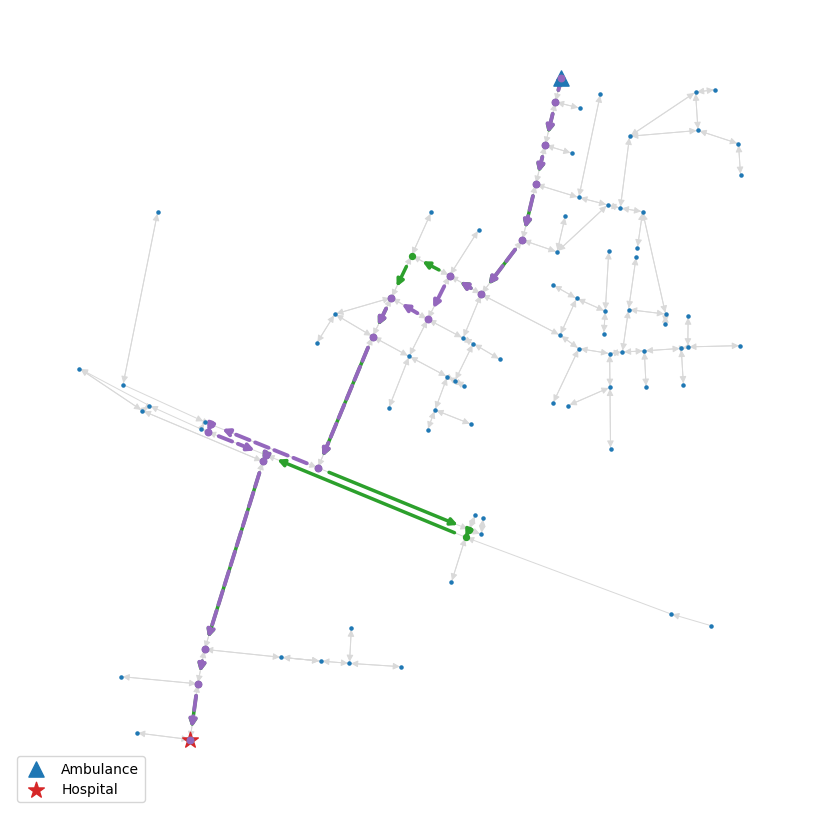

In [25]:
# ------------------------------------------------------------
# Rescue final path → Compare vs Classical → Plot
# ------------------------------------------------------------
import networkx as nx
import matplotlib.pyplot as plt

# 0) Ensure s,t and G_simple exist
s = globals().get('s', ambulance_node_id)
t = globals().get('t', hospital_node_id)

def to_simple_undirected(G_multi: nx.MultiDiGraph) -> nx.Graph:
    Gs = nx.Graph()
    for u, v, data in G_multi.edges(data=True):
        w = float(data.get("weight", data.get("length", 1.0)))
        a, b = (u, v) if u <= v else (v, u)
        if Gs.has_edge(a, b):
            if w < Gs[a][b]["weight"]:
                Gs[a][b]["weight"] = w
        else:
            Gs.add_edge(a, b, weight=w)
    return Gs

if 'G_simple' not in globals():
    G_simple = to_simple_undirected(G_proj)

# 1) Try to get a usable path
qaoa_path_final = None

if 'qaoa_path' in globals() and qaoa_path:
    qaoa_path_final = qaoa_path
elif 'qaoa_path_repaired' in globals() and qaoa_path_repaired:
    qaoa_path_final = qaoa_path_repaired
elif 'selected_edges' in globals() and selected_edges:
    # attempt to reconstruct a path from selected edges
    Gc = to_simple_undirected(G_proj.subgraph(G_proj.nodes()).copy()) if 'Gc' not in globals() else Gc
    H = nx.Graph()
    H.add_nodes_from(Gc.nodes())
    H.add_edges_from(selected_edges)
    if s in H and t in H and nx.has_path(H, s, t):
        qaoa_path_final = nx.shortest_path(H, s, t)

# If still missing, stop with a helpful hint
if not qaoa_path_final:
    raise RuntimeError("No QAOA path found in scope. Re-run the QAOA cell, or run your Repair+Prune cell to create qaoa_path_repaired.")

# 2) Classical baseline and costs
sp_classical = nx.shortest_path(G_simple, s, t, weight="weight")
cost_classical = sum(G_simple[sp_classical[i]][sp_classical[i+1]]["weight"]
                     for i in range(len(sp_classical)-1))
cost_qaoa = sum(G_simple[qaoa_path_final[i]][qaoa_path_final[i+1]]["weight"]
                for i in range(len(qaoa_path_final)-1))

delta = cost_qaoa - cost_classical
pct = (delta / cost_classical * 100.0) if cost_classical else float('nan')

print(f"Classical: len={len(sp_classical)}  cost≈{cost_classical:.2f}")
print(f"QAOA     : len={len(qaoa_path_final)}  cost≈{cost_qaoa:.2f}")
print(f"Δ cost   : {delta:+.2f}  ({pct:+.1f}%)")

# 3) Plot overlay
pos = {n: (G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in G_proj.nodes}

plt.figure(figsize=(8,8))
nx.draw(G_proj, pos=pos, node_size=5, width=0.7, edge_color='0.85')

nx.draw_networkx_edges(G_proj, pos,
    edgelist=list(zip(sp_classical[:-1], sp_classical[1:])),
    width=2.5, edge_color='tab:green', label='Classical SP')
nx.draw_networkx_nodes(G_proj, pos, nodelist=sp_classical, node_size=18, node_color='tab:green')

nx.draw_networkx_edges(G_proj, pos,
    edgelist=list(zip(qaoa_path_final[:-1], qaoa_path_final[1:])),
    width=2.8, edge_color='tab:purple', style='--', label='QAOA path')
nx.draw_networkx_nodes(G_proj, pos, nodelist=qaoa_path_final, node_size=22, node_color='tab:purple')

plt.scatter([G_proj.nodes[s]['x']], [G_proj.nodes[s]['y']], s=120, marker='^', color='tab:blue', label='Ambulance')
plt.scatter([G_proj.nodes[t]['x']], [G_proj.nodes[t]['y']], s=140, marker='*', color='tab:red', label='Hospital')

plt.legend(loc='lower left')
plt.axis('off'); plt.tight_layout(); plt.show()

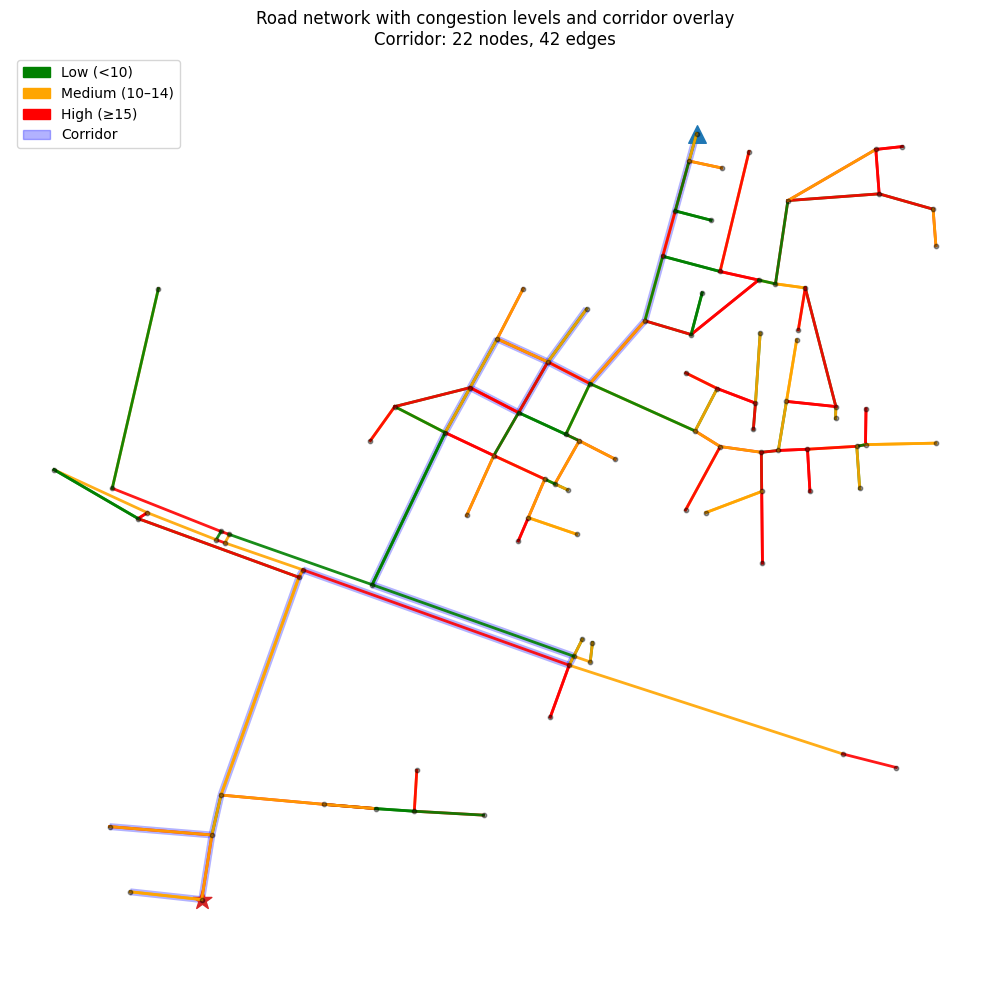

In [33]:
# ================================
# Visualize full graph with congestion colors + corridor highlight
# ================================
import matplotlib.pyplot as plt
import networkx as nx

# --- sanity checks ---
assert 'G_proj' in globals(), "G_proj missing."
assert 'G_corridor' in globals(), "G_corridor missing."
assert 's' in globals() and 't' in globals(), "Start 's' and end 't' nodes must be defined."

WEIGHT_ATTR = "weight"

# positions for plotting
pos = {n: (G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in G_proj.nodes}

# --- helper to pick color based on weight ---
def weight_to_color(w):
    if w < 10:     # low congestion
        return "green"
    elif w < 15:   # medium congestion
        return "orange"
    else:          # high congestion
        return "red"

# full plot
fig, ax = plt.subplots(figsize=(10, 10))

# draw all edges with congestion colors
for u, v, d in G_proj.edges(data=True):
    w = float(d.get(WEIGHT_ATTR, 1.0))
    color = weight_to_color(w)
    ax.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]],
            color=color, linewidth=2.0, alpha=0.9)

# ---- soft corridor highlight overlay ----
Gc_simple = nx.Graph()
for u, v, _ in G_corridor.edges(data=True):
    a, b = (u, v) if u < v else (v, u)
    if not Gc_simple.has_edge(a, b):
        Gc_simple.add_edge(a, b)

corr_edges = list(Gc_simple.edges())
# faint highlight overlay (cyan + transparency so congestion colors still show)
nx.draw_networkx_edges(Gc_simple, pos, edgelist=corr_edges,
                       width=5.0, edge_color='blue', alpha=0.30, ax=ax, label="Corridor")

# nodes: optional small dots
nx.draw_networkx_nodes(G_proj, pos, node_size=10, node_color='black', alpha=0.4, ax=ax)

# endpoints
ax.scatter([pos[s][0]], [pos[s][1]], s=160, marker='^', color='tab:blue', label='Ambulance Start')
ax.scatter([pos[t][0]], [pos[t][1]], s=200, marker='*', color='tab:red', label='Hospital')

# legend for congestion levels
import matplotlib.patches as mpatches
legend_elems = [
    mpatches.Patch(color="green", label="Low (<10)"),
    mpatches.Patch(color="orange", label="Medium (10–14)"),
    mpatches.Patch(color="red", label="High (≥15)"),
    mpatches.Patch(color="blue", alpha=0.30, label="Corridor"),
]
ax.legend(handles=legend_elems, loc="upper left")

ax.set_title(f"Road network with congestion levels and corridor overlay\n"
             f"Corridor: {G_corridor.number_of_nodes()} nodes, {G_corridor.number_of_edges()} edges")
ax.axis("off")
plt.tight_layout()
plt.show()